# Análise e predição de atrasos em compras on-line
-----------
### Criação de um modelo de aprendizado de máquina para ajudar a prever atrasos em entregas de compras em uma loja on-line com o objetivo de aumentar a retenção de clientes.

## 1. Introdução

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from utils import standardise_column_names, plot_boxplots, distribution_plot

chain = pd.read_csv('supply_chain.csv', encoding='latin-1')
chain = standardise_column_names(chain)
chain.head(10)

c:\Users\mathe\miniconda3\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
c:\Users\mathe\miniconda3\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


,type,days_for_shipping_real,days_for_shipment_scheduled,benefit_per_order,sales_per_customer,delivery_status,late_delivery_risk,category_id,category_name,customer_city,...,order_zipcode,product_card_id,product_category_id,product_description,product_image,product_name,product_price,product_status,shipping_date_dateorders,shipping_mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class
5,TRANSFER,6,4,18.580000,294.980011,Shipping canceled,0,73,Sporting Goods,Tonawanda,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/19/2018 11:03,Standard Class
6,DEBIT,2,1,95.180000,288.420013,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 10:42,First Class
7,TRANSFER,2,1,68.430000,285.140015,Late delivery,1,73,Sporting Goods,Miami,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 10:21,First Class
8,CASH,3,2,133.720001,278.589996,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 10:00,Second Class
9,CASH,2,1,132.149994,275.309998,Late delivery,1,73,Sporting Goods,San Ramon,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 9:39,First Class


In [2]:
chain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   type                         180519 non-null  object 
 1   days_for_shipping_real       180519 non-null  int64  
 2   days_for_shipment_scheduled  180519 non-null  int64  
 3   benefit_per_order            180519 non-null  float64
 4   sales_per_customer           180519 non-null  float64
 5   delivery_status              180519 non-null  object 
 6   late_delivery_risk           180519 non-null  int64  
 7   category_id                  180519 non-null  int64  
 8   category_name                180519 non-null  object 
 9   customer_city                180519 non-null  object 
 10  customer_country             180519 non-null  object 
 11  customer_email               180519 non-null  object 
 12  customer_fname               180519 non-null  object 
 13 

In [3]:
chain[chain.customer_id == 3329][['customer_id','customer_fname', 'delivery_status', 'order_item_id','days_for_shipping_real', 'product_price', 'order_status', 'order_id']]

,customer_id,customer_fname,delivery_status,order_item_id,days_for_shipping_real,product_price,order_status,order_id
681,3329,Joshua,Shipping canceled,15435,2,59.990002,SUSPECTED_FRAUD,6176
12313,3329,Joshua,Late delivery,66965,6,50.000000,COMPLETE,26735
57355,3329,Joshua,Late delivery,153086,6,50.000000,COMPLETE,61195
74976,3329,Joshua,Advance shipping,102887,2,199.990005,PENDING_PAYMENT,41221
104460,3329,Joshua,Shipping canceled,15437,2,49.980000,SUSPECTED_FRAUD,6176
104461,3329,Joshua,Shipping canceled,15436,2,49.980000,SUSPECTED_FRAUD,6176
132215,3329,Joshua,Late delivery,66967,6,49.980000,COMPLETE,26735
132216,3329,Joshua,Late delivery,66966,6,49.980000,COMPLETE,26735
137198,3329,Joshua,Late delivery,153085,6,399.980011,COMPLETE,61195
147954,3329,Joshua,Advance shipping,102888,2,399.980011,PENDING_PAYMENT,41221


In [4]:
chain.delivery_status.unique()

array(['Advance shipping', 'Late delivery', 'Shipping on time',
       'Shipping canceled'], dtype=object)

In [5]:
chain.delivery_status.value_counts()

Late delivery        98977
Advance shipping     41592
Shipping on time     32196
Shipping canceled     7754
Name: delivery_status, dtype: int64

In [6]:
len(chain)

180519

In [7]:
constant_columns = [col for col in chain.columns if chain[col].nunique() == 1]
# every column that endswith "id"
id_columns = [col for col in chain.columns if col.endswith('id')]
not_wanted_columns = ['product_image', 'product_description'] + id_columns


data = chain.drop(columns=not_wanted_columns + constant_columns)
data.head()

,type,days_for_shipping_real,days_for_shipment_scheduled,benefit_per_order,sales_per_customer,delivery_status,late_delivery_risk,category_name,customer_city,customer_country,...,order_item_total,order_profit_per_order,order_region,order_state,order_status,order_zipcode,product_name,product_price,shipping_date_dateorders,shipping_mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,...,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,Smart watch,327.75,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,Sporting Goods,Caguas,Puerto Rico,...,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,Smart watch,327.75,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,Sporting Goods,San Jose,EE. UU.,...,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,Smart watch,327.75,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,Sporting Goods,Los Angeles,EE. UU.,...,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,Smart watch,327.75,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,...,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,Smart watch,327.75,1/15/2018 11:24,Standard Class


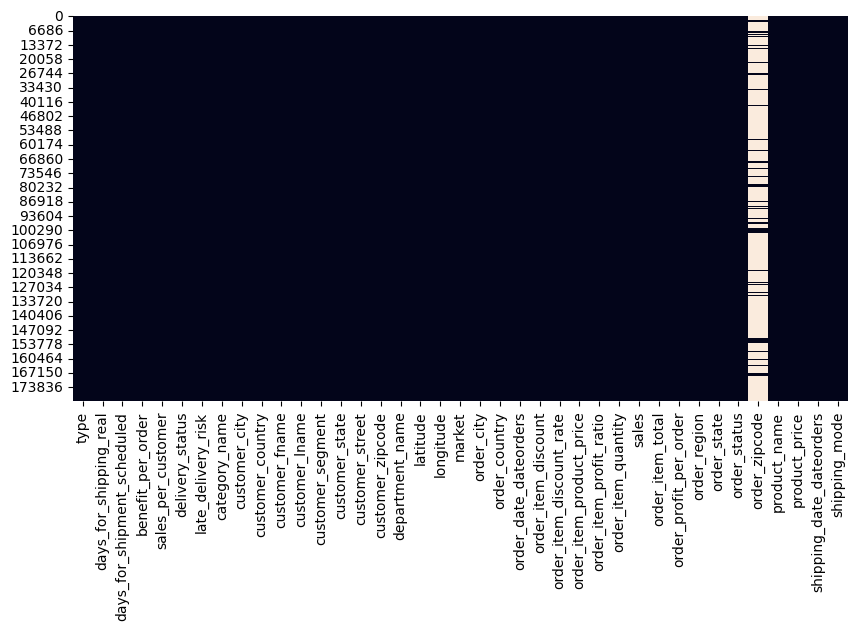

In [8]:
# nan matrix
plt.figure(figsize=(10, 5))
sns.heatmap(data.isnull(), cbar=False)
plt.show()

In [9]:
# drop zip code
data = data.drop(columns=['order_zipcode'])

In [10]:
cat_cols = data.select_dtypes(include='object').columns.tolist()
num_cols = data.select_dtypes(include='number').columns.tolist()

# print columns names with index numbers and make a line with 3 column names and then break line
print("Categorical Columns: ")
for i, col in enumerate(cat_cols, 1):
    print(f'{i:2}. {col:20}', end='\t')
    if i % 3 == 0:
        print()

print("\nNumerical Columns: ")
for i, col in enumerate(num_cols, 1):
    print(f'{i:2}. {col:20}', end='\t')
    if i % 3 == 0:
        print()


Categorical Columns: 
 1. type                	 2. delivery_status     	 3. category_name       	
 4. customer_city       	 5. customer_country    	 6. customer_fname      	
 7. customer_lname      	 8. customer_segment    	 9. customer_state      	
10. customer_street     	11. department_name     	12. market              	
13. order_city          	14. order_country       	15. order_date_dateorders	
16. order_region        	17. order_state         	18. order_status        	
19. product_name        	20. shipping_date_dateorders	21. shipping_mode       	

Numerical Columns: 
 1. days_for_shipping_real	 2. days_for_shipment_scheduled	 3. benefit_per_order   	
 4. sales_per_customer  	 5. late_delivery_risk  	 6. customer_zipcode    	
 7. latitude            	 8. longitude           	 9. order_item_discount 	
10. order_item_discount_rate	11. order_item_product_price	12. order_item_profit_ratio	
13. order_item_quantity 	14. sales               	15. order_item_total    	
16. order_profit_per

In [11]:
data.columns

Index(['type', 'days_for_shipping_real', 'days_for_shipment_scheduled',
       'benefit_per_order', 'sales_per_customer', 'delivery_status',
       'late_delivery_risk', 'category_name', 'customer_city',
       'customer_country', 'customer_fname', 'customer_lname',
       'customer_segment', 'customer_state', 'customer_street',
       'customer_zipcode', 'department_name', 'latitude', 'longitude',
       'market', 'order_city', 'order_country', 'order_date_dateorders',
       'order_item_discount', 'order_item_discount_rate',
       'order_item_product_price', 'order_item_profit_ratio',
       'order_item_quantity', 'sales', 'order_item_total',
       'order_profit_per_order', 'order_region', 'order_state', 'order_status',
       'product_name', 'product_price', 'shipping_date_dateorders',
       'shipping_mode'],
      dtype='object')

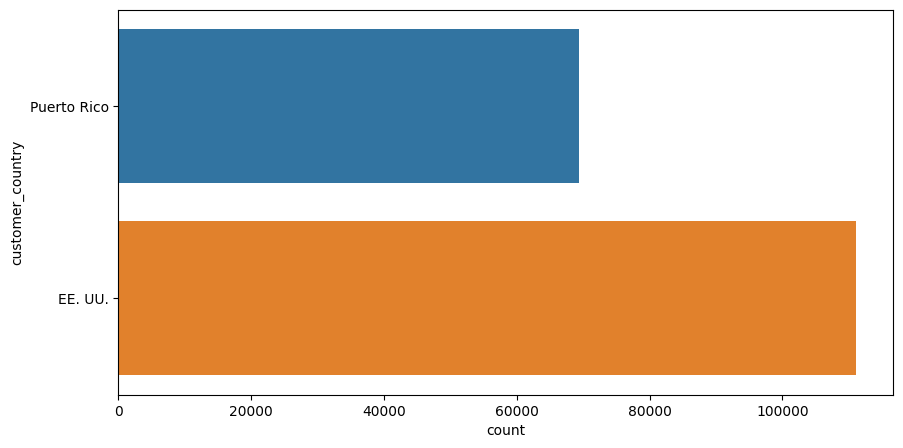

In [12]:
# plot the most common customer countries using seaborn

plt.figure(figsize=(10, 5))
sns.countplot(data=data, y='customer_country')
plt.show()

In [14]:
data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
days_for_shipping_real,180519.0,3.497654,1.623722,0.000000,2.000000,3.000000,5.000000,6.000000
days_for_shipment_scheduled,180519.0,2.931847,1.374449,0.000000,2.000000,4.000000,4.000000,4.000000
benefit_per_order,180519.0,21.974989,104.433526,-4274.979980,7.000000,31.520000,64.800003,911.799988
sales_per_customer,180519.0,183.107609,120.043670,7.490000,104.379997,163.990005,247.399994,1939.989990
late_delivery_risk,180519.0,0.548291,0.497664,0.000000,0.000000,1.000000,1.000000,1.000000
customer_zipcode,180516.0,35921.126914,37542.461122,603.000000,725.000000,19380.000000,78207.000000,99205.000000
latitude,180519.0,29.719955,9.813646,-33.937553,18.265432,33.144863,39.279617,48.781933
longitude,180519.0,-84.915675,21.433241,-158.025986,-98.446312,-76.847908,-66.370583,115.263077
order_item_discount,180519.0,20.664741,21.800901,0.000000,5.400000,14.000000,29.990000,500.000000
order_item_discount_rate,180519.0,0.101668,0.070415,0.000000,0.040000,0.100000,0.160000,0.250000


### Algumas observações
- A loja é de roupa, esportes e componentes eletrônicos.
- Vamos assumir que a moeda é o **dólar americano**.
- `benefit_per_order`: lucro por pedido. Temos desde um prejuízo de **4275.0** dólares até um positivo de **911.8** dólares.
- `product_price`: não tem itens muito caros, o mais caro é de **2 mil**.
- `order_item_quantity`: poucas quantidades por item
- `days_for_shipping_real` é **maior** em média do que o `days_for_shipment_scheduled`, indicando atrasos
- `late_delivery_risk`: indica se a entrega foi enviada com atraso (`days_for_shipping_real` > `days_for_shipment_scheduled`). Média de **0.54**, confirmando a observação anterior.
- `latitude` e `longitude` indicando as localidades das lojas de onde partem os pedidos

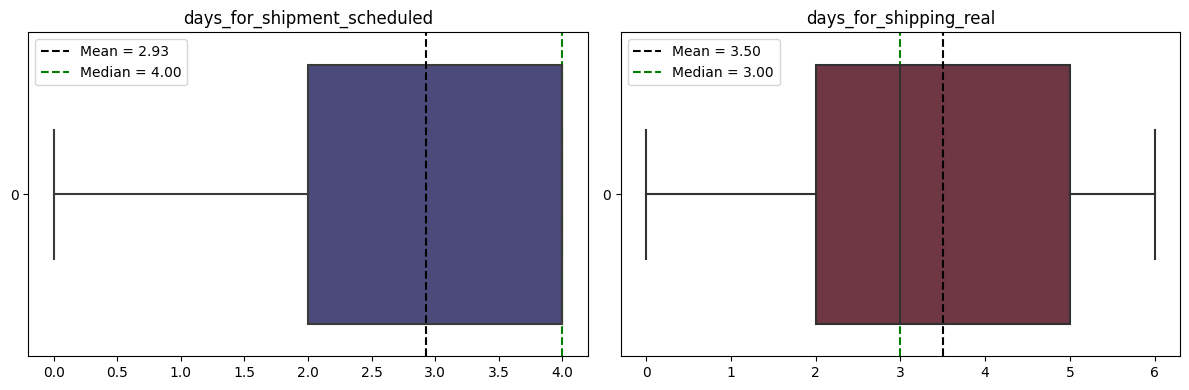

In [15]:
plot_boxplots(data, ['days_for_shipment_scheduled', 'days_for_shipping_real'])

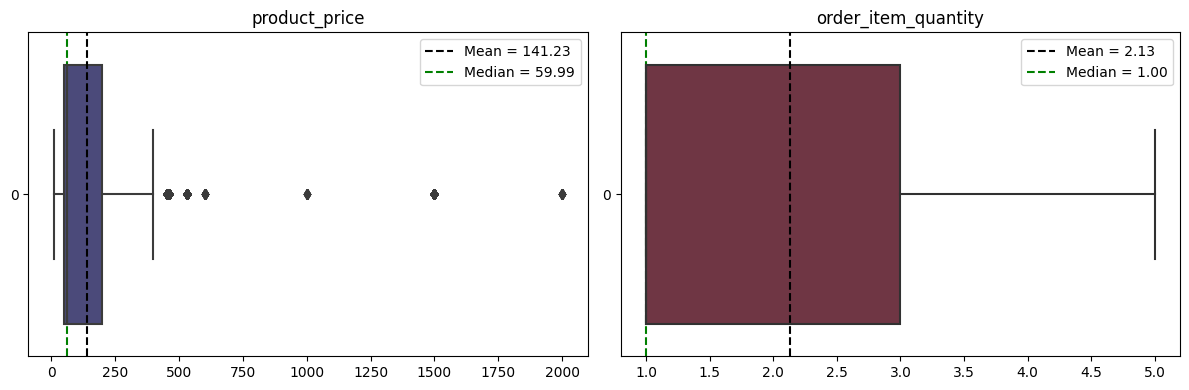

In [16]:
plot_boxplots(data, ['product_price', 'order_item_quantity'])

Alguns outliers nos preços dos produtos

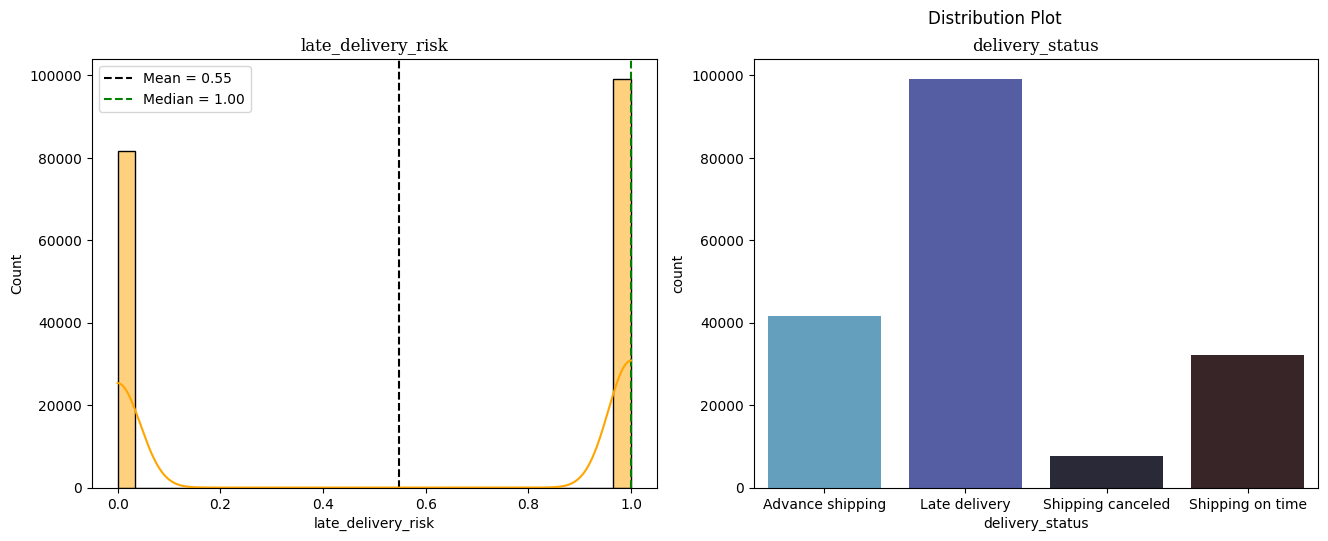

In [25]:
distribution_plot(data, include_columns=['late_delivery_risk','delivery_status'])

UnboundLocalError: local variable 'i' referenced before assignment

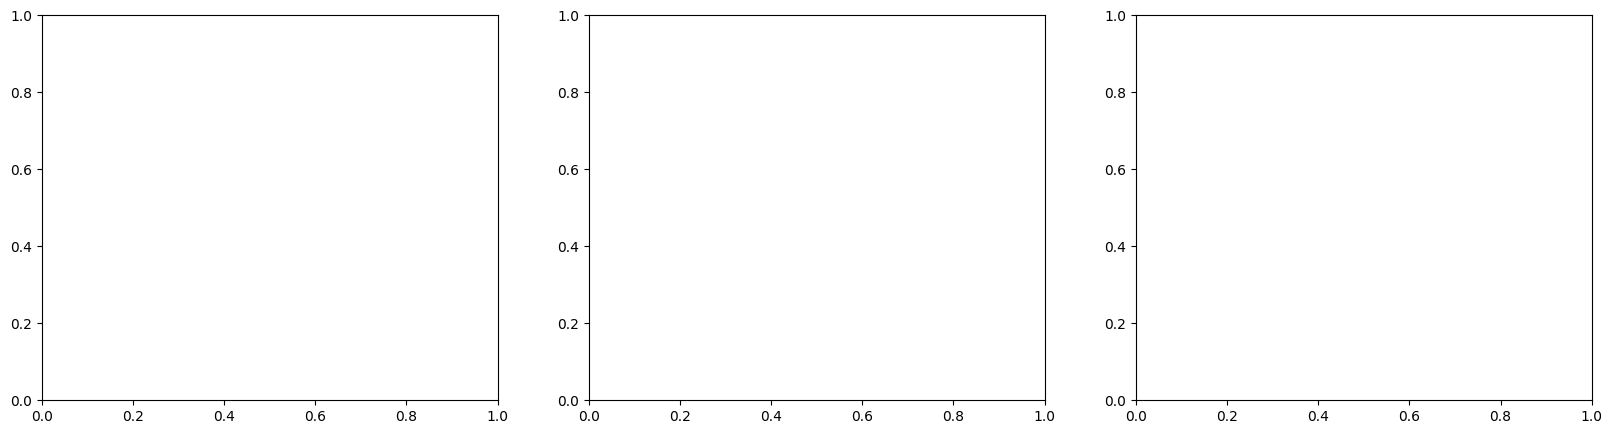

In [27]:
distribution_plot(data, include_columns=['order_status'])